In [0]:
!pip install librosa
import librosa as lb
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from google.colab import drive,files
drive.mount('/gdrive')
%cd /gdrive/My\ Drive
''' convert to wav
!ffmpeg -i with\ break.caf break.wav
!ffmpeg -i pitch\ glide.m4a glide.wav '''

In [0]:
def fund_find(nm,plot):
  s,fs=lb.core.load(nm)
  s/=sp.stats.iqr(s)
  nfft=1024
  spolap=nfft*.9
  f,t,sx = sp.signal.stft(s, nperseg=nfft, fs=fs, noverlap=spolap,window=np.hamming(nfft))
  sx=np.abs(sx)

  w=600
  ln=s.shape[0]
  cc=w//4
  thr=20
  lap=.8
  smth=4
  spcav=10
  stp=int(w*(1-lap))
  wn=(ln-w)//stp
  ff=np.zeros([wn,w])
  fufr=np.zeros(wn)
  fucn=np.zeros(wn)
  ent=np.ones(wn)
  for i in range(spcav,wn-spcav):
    ch=s[i*stp:i*stp+w]
    ff[i,:]=np.abs(np.fft.fft(ch*np.hamming(w)))
    pks,_=sp.signal.find_peaks(ff[i,:cc//4],distance=5,height=thr)
    if pks.shape[0]>0:
      fufr[i]=np.min(pks)/w*fs
    ent[i]=entropy(ff[i,:])/np.sum(np.sum(ff[i-spcav:i,:],axis=0)+1e-6)
    ent[i]=1/(ent[i]+1e-4)
    if fufr[i]<100:
      ent[i]=0

  frar=fufr
  entar=ent
  for j in range(smth,fufr.shape[0]-smth):
    fufr[j]=np.median(frar[j-smth:j+smth+1])  
    ent[j]=np.mean(entar[j-smth:j+smth+1])
  if plot==1:
    fig=plt.figure(figsize=[20,8])
    ax0=plt.axes()
    ax0.imshow(sx[int(np.max(fufr)/fs*2*sx.shape[0])::-1,:],vmin=0,vmax=np.amax(sx)/10,extent=[0,wn,0,np.amax(fufr)],aspect='auto')
    ax0.plot(fufr,color=[.2,.6,0],linewidth=2)
    ax0.plot(ent/np.max(ent)*np.max(fufr),color='orange',linewidth=2)
    plt.title(nm)
    plt.ylabel('Frequency, Hz')
    plt.xlabel('Window number')
    plt.legend(['pitch frequency','stability'])
  return fufr,ent

def entropy(s):
  h,edg=np.histogram(s,bins=200)
  h=h/np.sum(h+1e-6)
  ent=-np.sum(h*np.log2(h+1e-6))
  return ent

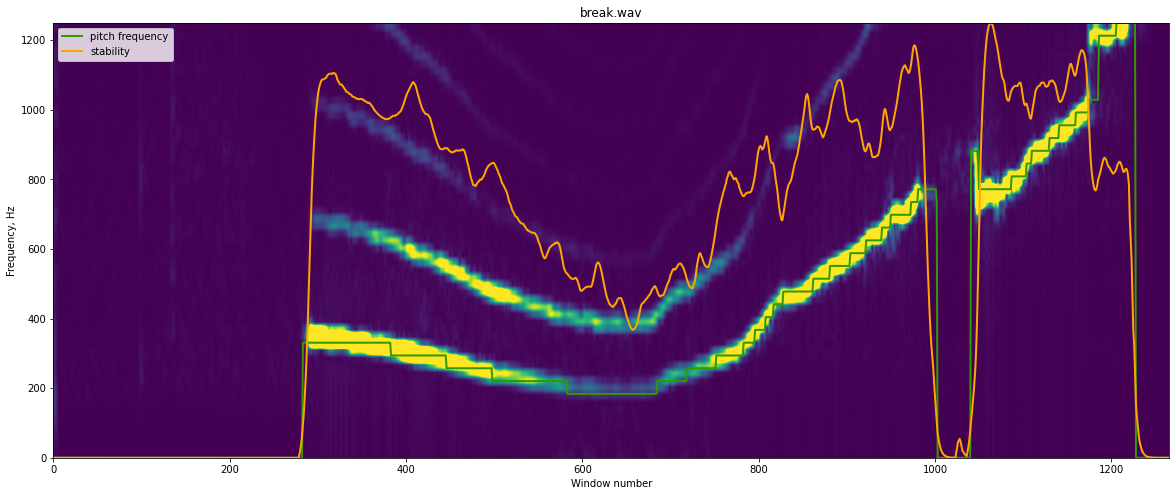

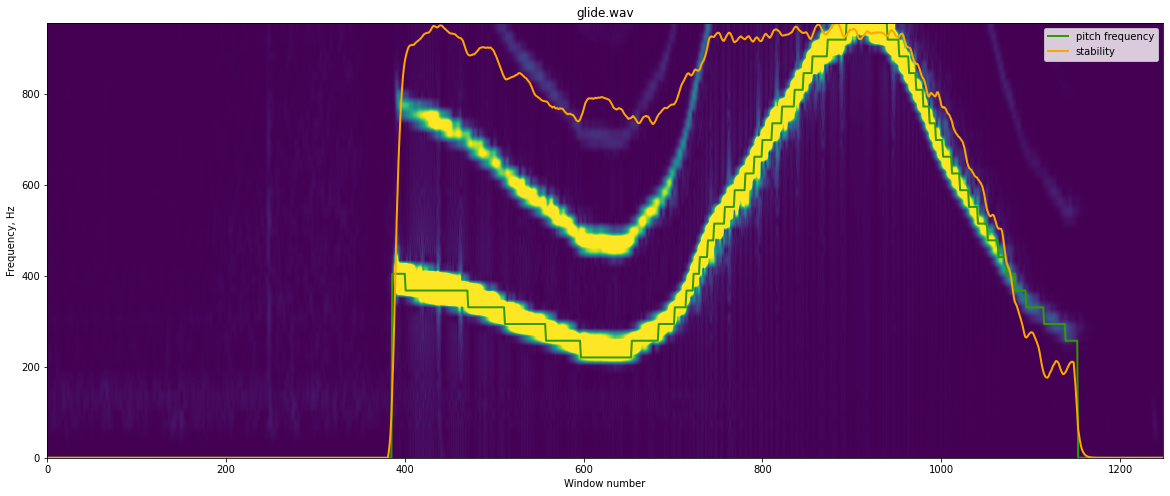

In [0]:
files=['break.wav','glide.wav']
fufrs=[]
ents=[]
for nm in files:
  #arguments are name and 1/0 for plotting
  fufr,ent=fund_find(nm,1) 
  fufrs.append(fufr)
  ents.append(ent)  

Lowest and highest frequency:
break.wav: 220  Hz 808  Hz
glide.wav: 257  Hz 845  Hz


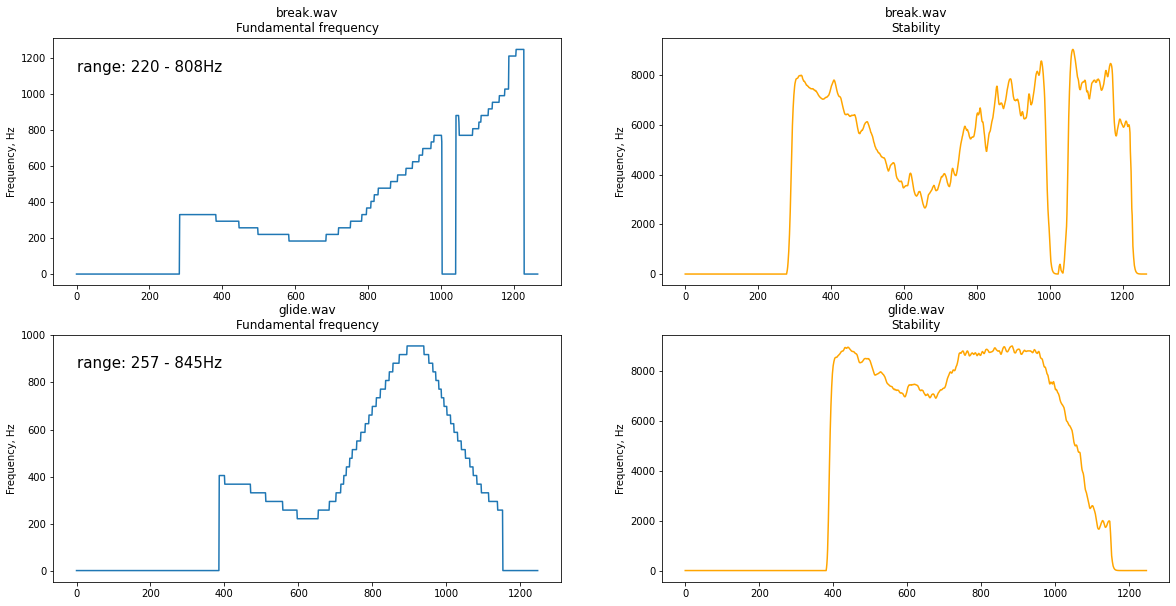

In [0]:
#output
ln=len(fufrs)
fig,ax=plt.subplots(ln,2,figsize=[20,5*ln])
print('Lowest and highest frequency:')
for i in range(ln):
  fl=fufrs[i]
  fl = list(filter(lambda x: (x>0), fl))  
  q0=int(np.quantile(fl,.15))
  q1=int(np.quantile(fl,.85))
  print(files[i]+':',q0,' Hz',q1,' Hz')
  ax[i,0].plot(fufrs[i])
  ax[i,1].plot(ents[i],'orange')
  ax[i,0].set_title(files[i]+"\nFundamental frequency")
  ax[i,1].set_title(files[i]+"\nStability")
  ax[i,0].set_ylabel('Frequency, Hz')
  ax[i,1].set_ylabel('Frequency, Hz')
  ax[i,0].text(0, np.max(fufrs[i])*.9, 'range: '+str(q0)+' - '+str(q1)+'Hz',fontsize=15)